In [17]:
!pip install numpy pandas plotly scikit-learn

Defaulting to user installation because normal site-packages is not writeable


## Whole Process


* Dataset Details:

Our NYC Schools dataset contains information about approximately 80,000 students applying to NYC public high schools.

Each student record includes:

Academic performance metrics (GPA, standardized test scores)

Demographic indicators (income status, ELL status, special education status)

Geographic information (borough, district)

Previous school performance

Extracurricular activities and achievements"

* Protected attributes we focused on:

Low-income status (based on free/reduced lunch eligibility)

English Language Learner (ELL) status

Special Education needs

Economic Need Index (ENI) of student's neighborhood"

# Input Phase:

Starts with student data generation that creates realistic achievement gaps

Calculates base scores combining GPA and test scores

Why: Creates a foundation that reflects real-world educational disparities


# Core DCA Process:

Initializes bonus vector based on initial disparities

Repeatedly samples students and calculates adjusted scores

Selects top K% based on adjusted scores

Measures resulting disparities

Updates bonus vector based on observed disparities

Why: Iteratively refines the compensation to reduce demographic disparities while maintaining merit-based selection


# Refinement Phase:

Uses Adam optimizer for fine-tuning

Calculates final metrics

Returns optimized bonus vector

Why: Ensures the final solution is optimal and stable

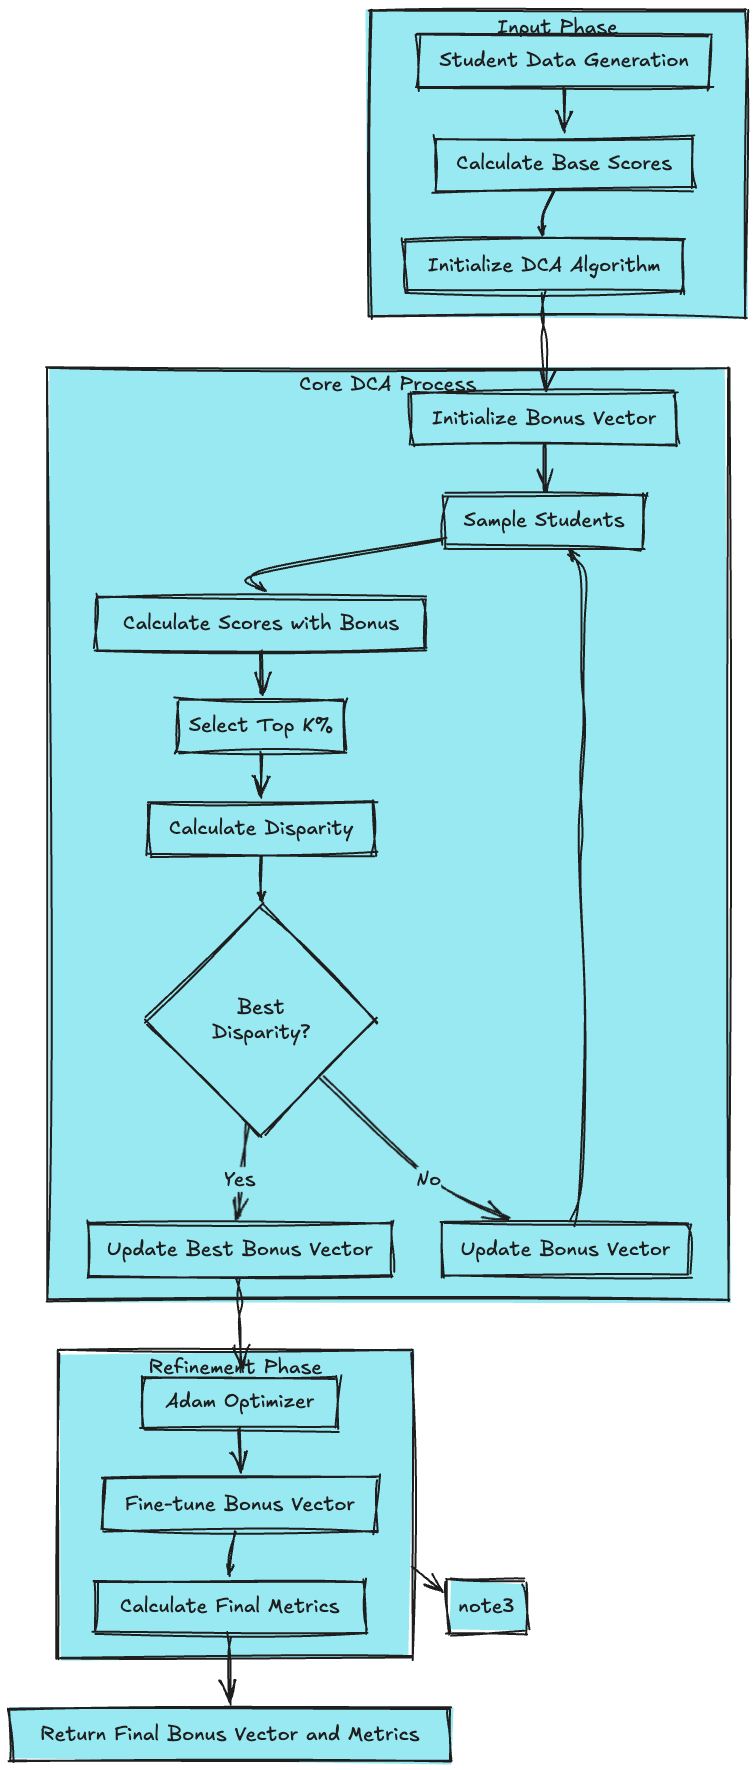


# Summary

Realistic Data Generation: The StudentDataGenerator creates data that reflects real-world achievement gaps, making the algorithm testing more meaningful.

Multiple Learning Rates: The DCA uses a sequence of decreasing learning rates to avoid local optima and ensure stable convergence.

Adam Refinement: The final refinement phase uses the Adam optimizer to fine-tune the bonus vector, improving the final results.

Granularity Control: The bonus points are rounded to a specified granularity, making the system more practical and interpretable.

In [26]:
%%writefile dca_core.py

# dca_core.py

# dca_core.py

import numpy as np
import logging
import random
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
import math

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set random seeds
np.random.seed(42)
random.seed(42)

@dataclass
class Student:
    """Student class to hold individual student data"""
    id: int
    gpa: float
    test_score: float
    base_score: float
    low_income: bool
    ell: bool  # English Language Learner
    special_ed: bool
    eni: float  # Economic Need Index

    @property
    def fairness_attributes(self) -> np.ndarray:
        """Return array of fairness attributes"""
        return np.array([
            float(self.low_income),
            float(self.ell),
            float(self.special_ed),
            self.eni
        ])

class StudentDataGenerator:
    """Generate simulated student data"""
    
    
    def __init__(self, num_students: int):
        if not isinstance(num_students, int):
            raise TypeError("num_students must be an integer")
            
        self.num_students = num_students
        # Demographics
        self.low_income_prop = 0.70  # 70% low income
        self.ell_prop = 0.10         # 10% ELL
        self.special_ed_prop = 0.15  # 15% special ed
        self.eni_mean = 0.60         # Mean ENI
        self.eni_std = 0.20          # ENI standard deviation
        
        # Achievement gaps
        self.achievement_gaps = {
            'low_income': -10,  # 10 point gap
            'ell': -15,        # 15 point gap
            'special_ed': -12  # 12 point gap
        }

    def generate_data(self) -> List[Student]:
        """Generate simulated student data with realistic achievement gaps"""
        students = []
        for i in range(self.num_students):
            # Generate protected attributes
            low_income = random.random() < self.low_income_prop
            ell = random.random() < self.ell_prop
            special_ed = random.random() < self.special_ed_prop
            
            # Generate base GPA
            base_gpa = np.random.normal(85, 10)
            
            # Apply achievement gaps
            if low_income:
                base_gpa += np.random.normal(self.achievement_gaps['low_income'], 2)
            if ell:
                base_gpa += np.random.normal(self.achievement_gaps['ell'], 2)
            if special_ed:
                base_gpa += np.random.normal(self.achievement_gaps['special_ed'], 2)
            
            # Ensure GPA is within valid range
            base_gpa = np.clip(base_gpa, 0, 100)
            
            # Generate correlated test score
            gap_factor = sum([low_income, ell, special_ed]) * 0.1
            test_score = (0.8 - gap_factor) * base_gpa + \
                        (0.2 + gap_factor) * np.random.normal(75, 15)
            test_score = np.clip(test_score, 0, 100)
            
            # Generate ENI with correlation to low_income
            eni_offset = 0.2 if low_income else -0.2
            eni = min(1.0, max(0.0, np.random.normal(self.eni_mean + eni_offset, self.eni_std)))
            
            # Calculate base score
            base_score = 0.55 * base_gpa + 0.45 * test_score

            students.append(Student(
                id=i,
                gpa=base_gpa,
                test_score=test_score,
                base_score=base_score,
                low_income=low_income,
                ell=ell,
                special_ed=special_ed,
                eni=eni
            ))
        return students

class DCA:
    """Disparity Compensation Algorithm Implementation"""

    """
        What: Initializes the DCA algorithm with configuration parameters
        Why: To set up the algorithm with proper learning parameters and constraints
        Result: Creates a new DCA instance with specified parameters and empty history trackers
    """
    
    def __init__(
        self,
        learning_rates: Optional[List[float]] = None,
        num_iterations: int = 100,
        sample_size: int = 500,
        granularity: float = 0.5,
        max_bonus_points: float = 20.0
    ):
        self.learning_rates = learning_rates or [1.0, 0.5, 0.1]
        self.num_iterations = num_iterations
        self.sample_size = sample_size
        self.granularity = granularity
        self.max_bonus_points = max_bonus_points
        self.num_fairness_attributes = 4
        
        # Track metrics
        self.disparity_history = []
        self.bonus_history = []

    """
        What: Calculates the average position of fairness attributes across all students
        Why: To establish a reference point for measuring demographic representation
        Result: Returns a numpy array of length 4 containing the mean values of each fairness attribute
    """

    def calculate_centroid(self, objects: List[Student]) -> np.ndarray:
        """Calculate centroid of fairness attributes"""
        if not objects:
            return np.zeros(self.num_fairness_attributes)
        fairness_attrs = np.array([obj.fairness_attributes for obj in objects])
        return np.mean(fairness_attrs, axis=0)

    """
        What: Combines base scores with weighted bonus points for each student
        Why: To adjust student scores based on demographic factors while preserving relative merit
        Result: Returns an array of adjusted scores where each score = base_score + (fairness_attributes · bonus_vector)
    """

    def calculate_scores(self, objects: List[Student], bonus_vector: np.ndarray) -> np.ndarray:
        """Calculate scores with bonus points applied"""
        if not objects:
            return np.array([])
        base_scores = np.array([obj.base_score for obj in objects])
        bonus_scores = np.array([np.dot(obj.fairness_attributes, bonus_vector) for obj in objects])
        return base_scores + bonus_scores

    """
        What: Selects the top k% of students based on their adjusted scores
        Why: To simulate selection processes (like admissions) with a fixed capacity constraint
        Result: Returns a list of Student objects representing the top k% based on adjusted scores
    """

    def select_top_k_percent(self, objects: List[Student], scores: np.ndarray, k: float) -> List[Student]:
        """Select top k% of objects based on scores"""
        if not objects or k <= 0:
            return []
        num_to_select = max(1, int(len(objects) * k))
        indices = np.argsort(scores)[-num_to_select:]
        return [objects[i] for i in indices]

    """
        What: Measures the difference in demographic representation between selected and overall population
        Why: To quantify how well the current bonus points are reducing demographic disparities
        Result: Returns a numpy array representing the difference between selected group centroid and overall centroid
    """

    def calculate_disparity(self, objects: List[Student], k: float, bonus_vector: np.ndarray) -> np.ndarray:
        """Calculate disparity"""
        if not objects:
            return np.zeros(self.num_fairness_attributes)
            
        D_O = self.calculate_centroid(objects)
        scores = self.calculate_scores(objects, bonus_vector)
        selected = self.select_top_k_percent(objects, scores, k)
        D_k = self.calculate_centroid(selected)
        
        return D_k - D_O

    """
        What: Creates initial bonus points based on observed demographic disparities
        Why: To start the optimization process with a reasonable estimate that counteracts existing disparities
        Result: Returns a numpy array of initial bonus points clipped to maximum allowed values
    """
    def initialize_bonus_vector(self, objects: List[Student], k: float) -> np.ndarray:
        """Initialize bonus vector based on initial disparities"""
        initial_disparity = self.calculate_disparity(
            objects, k, np.zeros(self.num_fairness_attributes))
        initial_bonus = -initial_disparity * 10.0
        return np.clip(initial_bonus, 0, self.max_bonus_points)

     """
        What: Adjusts bonus points based on observed disparities using momentum
        Why: To gradually improve the bonus points while maintaining stability in the optimization process
        Result: Returns an updated bonus vector with granularity constraints and clipping applied
     """

    def update_bonus_vector(self, current_B: np.ndarray, D_k: np.ndarray, 
                          learning_rate: float, iteration: int) -> np.ndarray:
        """Update bonus vector"""
        momentum = min(0.9, iteration / 100)
        gradient = D_k * (1 - momentum)
        new_B = current_B - learning_rate * gradient
        new_B = np.clip(new_B, 0, self.max_bonus_points)
        return np.round(new_B / self.granularity) * self.granularity

    """
        What: Fine-tunes bonus vector using the Adam optimizer algorithm
        Why: To improve the final result using an advanced optimization technique that adapts to the geometry of the data
        Result: Returns a refined bonus vector that minimizes disparities while respecting constraints
        
        Details:
        - Uses adaptive moment estimation (Adam) with bias correction
        - Maintains running averages of gradients and their squares
        - Adjusts learning rates based on parameter-specific scales
    """

    def run_adam_refinement(self, objects: List[Student], k: float, B_initial: np.ndarray) -> np.ndarray:
        """Refinement step using Adam optimizer"""
        beta1, beta2 = 0.9, 0.999
        epsilon = 1e-8
        learning_rate = 0.001
        
        m = np.zeros_like(B_initial)
        v = np.zeros_like(B_initial)
        B = B_initial.copy()
        
        best_B = B.copy()
        best_disparity = float('inf')
        
        for t in range(1, self.num_iterations + 1):
            sample = random.sample(objects, min(len(objects), self.sample_size * 2))
            D_k = self.calculate_disparity(sample, k, B)
            disparity_norm = float(np.linalg.norm(D_k))
            
            if disparity_norm < best_disparity:
                best_disparity = disparity_norm
                best_B = B.copy()
            
            m = beta1 * m + (1 - beta1) * D_k
            v = beta2 * v + (1 - beta2) * np.square(D_k)
            m_hat = m / (1 - beta1**t)
            v_hat = v / (1 - beta2**t)
            
            B = B - learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
            B = np.clip(B, 0, self.max_bonus_points)
        
        return np.round(best_B / self.granularity) * self.granularity

    """
        What: Executes the complete DCA optimization pipeline
        Why: To find optimal bonus points that reduce demographic disparities while maintaining merit-based selection
        Result: Returns a tuple containing:
            1. Final optimized bonus vector
            2. Dictionary of metrics including:
               - History of disparities
               - History of bonus vectors
               - Final disparity norm
        
        Process:
        1. Initialize bonus vector
        2. Iterate through multiple learning rates
        3. Sample students and update bonus points
        4. Track best solution
        5. Apply Adam refinement
        6. Calculate final metrics
    """    
    def run(self, objects: List[Student], k: float) -> Tuple[np.ndarray, Dict]:
        """Complete DCA pipeline"""
        # Initialize
        B = self.initialize_bonus_vector(objects, k)
        best_B = B.copy()
        best_disparity_norm = float('inf')
        
        # Core DCA
        for learning_rate in self.learning_rates:
            logger.info(f"Starting iterations with learning rate {learning_rate}")
            
            for iteration in range(self.num_iterations):
                sample = random.sample(objects, min(len(objects), self.sample_size))
                D_k = self.calculate_disparity(sample, k, B)
                disparity_norm = float(np.linalg.norm(D_k))
                
                if disparity_norm < best_disparity_norm:
                    best_disparity_norm = disparity_norm
                    best_B = B.copy()
                
                B = self.update_bonus_vector(B, D_k, learning_rate, iteration)
                
                self.disparity_history.append(disparity_norm)
                self.bonus_history.append(B.copy())
                
                if iteration % 10 == 0:
                    logger.info(f"Iteration {iteration}, Disparity norm: {disparity_norm:.4f}")
        
        # Refinement
        logger.info("Starting DCA Refinement")
        final_B = self.run_adam_refinement(objects, k, best_B)
        
        # Calculate final metrics
        metrics = {
            'disparity_history': self.disparity_history,
            'bonus_history': self.bonus_history,
            'final_disparity_norm': float(np.linalg.norm(
                self.calculate_disparity(objects, k, final_B)))
        }
        
        logger.info(f"Final bonus vector: {final_B}")
        logger.info(f"Final disparity norm: {metrics['final_disparity_norm']:.4f}")
        
        return final_B, metrics

Overwriting dca_core.py


In [27]:
%%writefile visualization_metrics.py

# visualization_metrics.py

# visualization_metrics.py

# visualization_metrics.py

import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from typing import List, Dict, Tuple, Optional
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class ExtendedEvaluationMetrics:
    """Extended evaluation metrics with additional visualization capabilities"""
    
    @staticmethod
    def calculate_ndcg(original_scores: np.ndarray, new_scores: np.ndarray, k: float) -> float:
        """Calculate normalized discounted cumulative gain"""
        def dcg(scores: np.ndarray, k: float) -> float:
            if len(scores) == 0:
                return 0.0
            n = max(1, int(len(scores) * k))
            top_scores = np.sort(scores)[-n:][::-1]
            gains = 2 ** top_scores - 1
            discounts = np.log2(np.arange(2, len(gains) + 2))
            return np.sum(gains / discounts)

        dcg_new = dcg(new_scores, k)
        dcg_ideal = dcg(original_scores, k)
        
        return dcg_new / dcg_ideal if dcg_ideal > 0 else 1.0

    @staticmethod
    def calculate_ndcg_vs_k(original_scores: np.ndarray, new_scores: np.ndarray, k_values: List[float]) -> List[float]:
        """Calculate NDCG for multiple k values"""
        return [ExtendedEvaluationMetrics.calculate_ndcg(original_scores, new_scores, k) for k in k_values]

    @staticmethod
    def calculate_exposure(ranking: np.ndarray, group_membership: np.ndarray) -> float:
        """Calculate exposure metric"""
        if len(ranking) == 0:
            return 0.0
        
        positions = np.arange(1, len(ranking) + 1)
        exposure_weights = 1.0 / np.log2(positions + 1)
        
        group_exposure = np.sum(exposure_weights[group_membership])
        group_size = np.sum(group_membership)
        
        return group_exposure / group_size if group_size > 0 else 0.0

    @staticmethod
    def calculate_multiple_k_disparities(
        dca,
        students: List,
        k_values: List[float],
        bonus_vector: np.ndarray
    ) -> Dict[float, Dict[str, float]]:
        """Calculate disparities for multiple k values"""
        results = {}
        
        for k in k_values:
            scores = dca.calculate_scores(students, bonus_vector)
            num_selected = int(len(students) * k)
            selected = [students[i] for i in np.argsort(scores)[-num_selected:]]
            
            disparities = {}
            fairness_attrs = ['low_income', 'ell', 'special_ed', 'eni']
            
            for attr in fairness_attrs:
                selected_mean = np.mean([float(getattr(s, attr)) for s in selected])
                overall_mean = np.mean([float(getattr(s, attr)) for s in students])
                disparities[attr] = selected_mean - overall_mean
            
            results[k] = disparities
        
        return results

    @staticmethod
    def calculate_logarithmic_discounted_disparity(
        dca,
        students: List,
        bonus_vector: np.ndarray,
        max_k: float = 0.5
    ) -> float:
        """Calculate logarithmic discounted disparity"""
        k_values = np.arange(0.1, max_k + 0.1, 0.1)
        total_disparity = 0.0
        Z = np.sum(1.0 / np.log2(np.arange(2, len(k_values) + 2)))
        
        for i, k in enumerate(k_values):
            disparity = dca.calculate_disparity(students, k, bonus_vector)
            weight = 1.0 / (np.log2(i + 2) * Z)
            total_disparity += weight * np.linalg.norm(disparity)
        
        return total_disparity

    @staticmethod
    def calculate_disparity_metrics(
        selected: List,
        overall: List,
        attributes: List[str]
    ) -> Tuple[Dict[str, float], float]:
        """Calculate disparity metrics for selected vs overall population"""
        disparities = {}
        
        for attr in attributes:
            selected_mean = np.mean([float(getattr(s, attr)) for s in selected])
            overall_mean = np.mean([float(getattr(s, attr)) for s in overall])
            disparities[attr] = selected_mean - overall_mean
        
        disparity_vector = np.array([disparities[attr] for attr in attributes])
        disparity_norm = float(np.linalg.norm(disparity_vector))
        
        return disparities, disparity_norm

class InteractivePlotlyVisualizer:
    """Create interactive visualizations with enhanced features"""
    
    def __init__(self):
        self.metrics = ExtendedEvaluationMetrics()
    
    def plot_convergence(self, 
                        iterations: List[int],
                        disparity_history: List[float],
                        bonus_history: List[np.ndarray]) -> go.Figure:
        """Create convergence plot"""
        fig = make_subplots(
            rows=2, cols=1,
            subplot_titles=('Disparity Norm Over Iterations', 'Bonus Points Evolution')
        )
        
        # Plot disparity convergence
        fig.add_trace(
            go.Scatter(x=iterations, y=disparity_history,
                      mode='lines', name='Disparity Norm',
                      line=dict(color='royalblue')),
            row=1, col=1
        )
        
        # Plot bonus points evolution
        bonus_history = np.array(bonus_history)
        attr_names = ['Low Income', 'ELL', 'Special Ed', 'ENI']
        colors = px.colors.qualitative.Set3
        
        for i, attr in enumerate(attr_names):
            fig.add_trace(
                go.Scatter(x=iterations, y=bonus_history[:, i],
                          mode='lines', name=f'{attr} Bonus',
                          line=dict(color=colors[i])),
                row=2, col=1
            )
        
        fig.update_layout(
            height=800,
            showlegend=True,
            title_text="DCA Convergence Analysis",
            template='plotly_white'
        )
        
        return fig

    def plot_disparity_ndcg_tradeoff(self,
                                    k_values: List[float],
                                    disparities: List[float],
                                    ndcg_values: List[float],
                                    exposures: Optional[List[float]] = None) -> go.Figure:
        """Plot disparity vs nDCG tradeoff"""
        fig = make_subplots(specs=[[{"secondary_y": True}]])
        
        fig.add_trace(
            go.Scatter(x=k_values, y=disparities, name="Disparity",
                      mode='lines+markers'),
            secondary_y=False
        )
        
        fig.add_trace(
            go.Scatter(x=k_values, y=ndcg_values, name="nDCG",
                      mode='lines+markers'),
            secondary_y=True
        )
        
        if exposures is not None:
            fig.add_trace(
                go.Scatter(x=k_values, y=exposures, name="Avg Exposure",
                          mode='lines+markers'),
                secondary_y=True
            )
        
        fig.update_layout(
            title='Disparity vs nDCG Tradeoff',
            xaxis_title='Proportion of total items selected',
            template='plotly_white'
        )
        
        fig.update_yaxes(title_text="Disparity", secondary_y=False)
        fig.update_yaxes(title_text="nDCG", secondary_y=True)
        
        return fig

    def plot_ndcg_performance(self, k_values: List[float], ndcg_values: List[float]) -> go.Figure:
        """Plot nDCG performance across different k values"""
        fig = go.Figure()
        
        fig.add_trace(go.Scatter(
            x=k_values,
            y=ndcg_values,
            mode='lines+markers',
            name='nDCG@k'
        ))
        
        fig.update_layout(
            title='nDCG Performance vs Selection Rate',
            xaxis_title='Proportion of total items selected (k)',
            yaxis_title='nDCG@k',
            template='plotly_white'
        )
        
        return fig

    def plot_disparity_components(self, bonus_points: List[float], 
                                disparities: Dict[str, List[float]]) -> go.Figure:
        """Plot disparity components for each protected group"""
        fig = go.Figure()
        
        for group, values in disparities.items():
            fig.add_trace(go.Scatter(
                x=bonus_points,
                y=values,
                mode='lines+markers',
                name=group
            ))
        
        fig.update_layout(
            title='Disparity Components by Protected Group',
            xaxis_title='Proportion of Bonus Points Assigned',
            yaxis_title='Disparity',
            template='plotly_white'
        )
        
        return fig

    def plot_disparity_by_k(self, k_values: List[float], 
                           original_disparities: Dict[str, List[float]],
                           final_disparities: Dict[str, List[float]]) -> go.Figure:
        """Plot disparities before and after DCA by k value"""
        fig = make_subplots(rows=2, cols=1,
                           subplot_titles=('Original Disparities', 'After DCA'))
        
        for group, values in original_disparities.items():
            fig.add_trace(
                go.Scatter(x=k_values, y=values,
                          mode='lines+markers',
                          name=f'{group} (original)'),
                row=1, col=1
            )
        
        for group, values in final_disparities.items():
            fig.add_trace(
                go.Scatter(x=k_values, y=values,
                          mode='lines+markers',
                          name=f'{group} (final)'),
                row=2, col=1
            )
        
        fig.update_layout(
            height=800,
            title_text="Disparities Before and After DCA",
            template='plotly_white'
        )
        
        fig.update_xaxes(title_text="Proportion of total items selected", row=1, col=1)
        fig.update_xaxes(title_text="Proportion of total items selected", row=2, col=1)
        fig.update_yaxes(title_text="Disparity", row=1, col=1)
        fig.update_yaxes(title_text="Disparity", row=2, col=1)
        
        return fig
    def plot_group_disparities(self,
                         k_values: List[float],
                         group_disparities: Dict[str, List[float]],
                         title: str = "Group-wise Disparities") -> go.Figure:
        """Plot disparities by protected group"""
        fig = go.Figure()
        colors = px.colors.qualitative.Set3
        
        for i, (group, disparities) in enumerate(group_disparities.items()):
            fig.add_trace(
                go.Scatter(x=k_values, y=disparities,
                          name=group,
                          mode='lines+markers',
                          line=dict(color=colors[i]))
            )
        
        fig.update_layout(
            title=title,
            xaxis_title='Selection Size (k)',
            yaxis_title='Disparity',
            template='plotly_white',
            hovermode='x unified'
        )
        
        return fig

    def create_report_visualizations(
        self,
        dca,
        students: List,
        bonus_vector: np.ndarray,
        training_metrics: Dict,
        k: float
    ) -> Dict[str, go.Figure]:
        """Create all visualizations for the report"""
        # Prepare data for plots
        iterations = list(range(len(training_metrics['disparity_history'])))
        k_values = np.linspace(0.05, 0.5, 10)
        
        # Initialize metrics
        disparities = []
        ndcgs = []
        exposures = []
        group_disparities = {
            'low_income': [], 'ell': [], 'special_ed': [], 'eni': []
        }
        original_group_disparities = {
            'low_income': [], 'ell': [], 'special_ed': [], 'eni': []
        }
        final_group_disparities = {
            'low_income': [], 'ell': [], 'special_ed': [], 'eni': []
        }
        
        # Calculate metrics
        original_scores = np.array([s.base_score for s in students])
        new_scores = dca.calculate_scores(students, bonus_vector)
        
        for k_val in k_values:
            # Calculate disparities
            orig_disparity = dca.calculate_disparity(students, k_val, np.zeros_like(bonus_vector))
            final_disparity = dca.calculate_disparity(students, k_val, bonus_vector)
            disparities.append(float(np.linalg.norm(final_disparity)))
            
            # Calculate NDCG
            ndcg = self.metrics.calculate_ndcg(original_scores, new_scores, k_val)
            ndcgs.append(ndcg)
            
            # Calculate exposure
            ranking = np.argsort(-new_scores)
            exp_vals = []
            for attr in ['low_income', 'ell', 'special_ed']:
                group_membership = np.array([getattr(students[i], attr) for i in ranking])
                exp_vals.append(self.metrics.calculate_exposure(ranking, group_membership))
            exposures.append(np.mean(exp_vals))
            
            # Calculate group disparities
            orig_disparities = self.metrics.calculate_multiple_k_disparities(
                dca, students, [k_val], np.zeros_like(bonus_vector))
            final_disparities = self.metrics.calculate_multiple_k_disparities(
                dca, students, [k_val], bonus_vector)
            
            for attr in group_disparities:
                group_disparities[attr].append(final_disparities[k_val][attr])
                original_group_disparities[attr].append(orig_disparities[k_val][attr])
                final_group_disparities[attr].append(final_disparities[k_val][attr])
        
        # Create and return all plots
        return {
            'convergence': self.plot_convergence(
                iterations, 
                training_metrics['disparity_history'],
                training_metrics['bonus_history']
            ),
            'ndcg_performance': self.plot_ndcg_performance(
                k_values, ndcgs
            ),
            'tradeoff': self.plot_disparity_ndcg_tradeoff(
                k_values, disparities, ndcgs, exposures
            ),
            'disparity_components': self.plot_disparity_components(
                k_values, group_disparities
            ),
            'disparity_by_k': self.plot_disparity_by_k(
                k_values, original_group_disparities, final_group_disparities
            ),
            'group_disparities': self.plot_group_disparities(
                k_values, group_disparities
            )
        }

Overwriting visualization_metrics.py


In [28]:
%%writefile report_generator.py

# report_generator.py

# report_generator.py

# report_generator.py

# report_generator.py

from typing import Dict, Optional
import plotly.io as pio
import logging
import json
from datetime import datetime

class ReportGenerator:
    """Generate comprehensive HTML reports for DCA experiments"""
    
    def _generate_disparity_rows(self, results):
        """Generate HTML rows for disparity changes table"""
        groups = {
            'low_income': 'Low Income',
            'ell': 'English Language Learner',
            'special_ed': 'Special Education',
            'eni': 'Economic Need Index'
        }
        
        rows = []
        for key, name in groups.items():
            initial = results['initial_disparities'][key]
            final = results['final_disparities'][key]
            improvement = ((initial - final) / abs(initial)) * 100 if initial != 0 else 0
            
            row = f'''
                <tr>
                    <td>{name}</td>
                    <td>{initial:.4f}</td>
                    <td>{final:.4f}</td>
                    <td>{improvement:.1f}%</td>
                </tr>
            '''
            rows.append(row)
        
        return '\n'.join(rows)

    def create_html_report(
        self,
        school_results: Dict,
        sensitivity_results: Dict,
        figures: Dict,
        experiment_params: Optional[Dict] = None,
        visualization_config: Optional[Dict] = None
    ) -> str:
        """Create detailed HTML report with interactive visualizations"""
        
        # Configure plotly
        pio.templates.default = "plotly_white"
        
        # Convert figures to HTML
        plots_html = {}
        try:
            for name, fig in figures.items():
                plots_html[name] = pio.to_html(
                    fig, 
                    full_html=False, 
                    include_plotlyjs='cdn',
                    include_mathjax='cdn',
                    default_width='100%',
                    default_height='600px'
                )
        except Exception as e:
            logging.error(f"Error converting plots to HTML: {str(e)}")
            plots_html = {key: '' for key in figures.keys()}

        # Generate HTML report
        html = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <title>DCA Experiment Results</title>
            <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
            <style>
                :root {{
                    --primary-color: #0d6efd;
                    --secondary-color: #6c757d;
                    --success-color: #198754;
                    --info-color: #0dcaf0;
                    --warning-color: #ffc107;
                    --danger-color: #dc3545;
                }}
                
                body {{
                    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
                    max-width: 1200px;
                    margin: 0 auto;
                    padding: 20px;
                    background-color: #f8f9fa;
                    line-height: 1.6;
                }}
                
                .section {{
                    margin-bottom: 30px;
                    padding: 25px;
                    border-radius: 10px;
                    background-color: white;
                    box-shadow: 0 2px 4px rgba(0,0,0,0.1);
                }}
                
                .metrics-section {{
                    margin: 30px 0;
                    padding: 20px;
                    background-color: #fff;
                    border-radius: 8px;
                    box-shadow: 0 1px 3px rgba(0,0,0,0.1);
                }}
                
                h2 {{
                    color: var(--primary-color);
                    margin-bottom: 20px;
                    padding-bottom: 10px;
                    border-bottom: 2px solid #eee;
                }}
                
                .plot-container {{
                    margin: 25px 0;
                    padding: 20px;
                    background-color: white;
                    border-radius: 10px;
                    box-shadow: 0 2px 4px rgba(0,0,0,0.1);
                    height: 600px;
                }}
                
                .chart-title {{
                    font-size: 1.2em;
                    color: var(--primary-color);
                    margin-bottom: 15px;
                    padding-bottom: 10px;
                    border-bottom: 2px solid #eee;
                }}
                
                .table {{
                    width: 100%;
                    border-collapse: collapse;
                    margin: 20px 0;
                    background-color: white;
                }}
                
                .table th, .table td {{
                    padding: 12px 16px;
                    border: 1px solid #dee2e6;
                    text-align: left;
                }}
                
                .table th {{
                    background-color: #f8f9fa;
                    font-weight: 600;
                    color: var(--secondary-color);
                }}
            </style>
        </head>
        <body>
            <div class="section">
                <h1>DCA Experiment Results</h1>
                <div class="info-box">
                    Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
                </div>
                
                <!-- Experiment Configuration -->
                <div class="metrics-section">
                    <h2>Experiment Configuration</h2>
                    <table class="table">
                        <tr>
                            <th>Number of Students</th>
                            <td>{experiment_params['num_students']:,}</td>
                        </tr>
                        <tr>
                            <th>Selection Rate (k)</th>
                            <td>{experiment_params['k']:.2f}</td>
                        </tr>
                        <tr>
                            <th>Sample Size</th>
                            <td>{experiment_params['sample_size']}</td>
                        </tr>
                    </table>
                </div>

                <!-- Metrics Summary -->
                <div class="metrics-section">
                    <h2>Results Summary</h2>
                    <table class="table">
                        <tr>
                            <th>Execution Time</th>
                            <td>{school_results['execution_time']:.2f} seconds</td>
                        </tr>
                        <tr>
                            <th>Initial Disparity</th>
                            <td>{school_results['initial_norm']:.4f}</td>
                        </tr>
                        <tr>
                            <th>Final Disparity</th>
                            <td>{school_results['final_norm']:.4f}</td>
                        </tr>
                        <tr>
                            <th>Disparity Reduction</th>
                            <td>{school_results['disparity_reduction']:.1f}%</td>
                        </tr>
                        <tr>
                            <th>nDCG</th>
                            <td>{school_results['ndcg']:.4f}</td>
                        </tr>
                    </table>
                </div>
            </div>
            
            <!-- Visualizations -->
            <div class="section">
                <h2>Algorithm Convergence</h2>
                <div class="plot-container">
                    {plots_html.get('convergence', '')}
                </div>
            </div>
            
            <div class="section">
                <h2>nDCG Performance</h2>
                <div class="plot-container">
                    {plots_html.get('ndcg_performance', '')}
                </div>
            </div>
            
            <div class="section">
                <h2>Disparity-nDCG Tradeoff</h2>
                <div class="plot-container">
                    {plots_html.get('tradeoff', '')}
                </div>
            </div>
            
            <div class="section">
                <h2>Group-wise Disparities</h2>
                <div class="plot-container">
                    {plots_html.get('group_disparities', '')}
                </div>
            </div>
            
            <div class="section">
                <h2>Disparity Components</h2>
                <div class="plot-container">
                    {plots_html.get('disparity_components', '')}
                </div>
            </div>
            
            <div class="section">
                <h2>Disparities Before and After DCA</h2>
                <div class="plot-container">
                    {plots_html.get('disparity_by_k', '')}
                </div>
            </div>
        </body>
        </html>
        """
        
        return html

    @staticmethod
    def save_results(results: Dict, filename: str = 'dca_results.json') -> None:
        """Save experiment results to JSON file"""
        try:
            with open(filename, 'w') as f:
                json.dump(results, f, indent=2)
            logging.info(f"Results saved to '{filename}'")
        except Exception as e:
            logging.error(f"Error saving results to '{filename}': {str(e)}")

    @staticmethod
    def save_report(report_html: str, filename: str = 'dca_report.html') -> None:
        """Save HTML report to file"""
        try:
            with open(filename, 'w') as f:
                f.write(report_html)
            logging.info(f"Report saved to '{filename}'")
        except Exception as e:
            logging.error(f"Error saving report to '{filename}': {str(e)}")

Overwriting report_generator.py


# Initialization Phase

Setup ExperimentRunner: Prepares all necessary components

Generate Student Data: Creates realistic test data with authentic achievement gaps

Split Train/Test: Ensures unbiased evaluation of the algorithm

Initialize DCA: Sets up the algorithm with specified parameters

Why: Establishes foundation for reliable experiment


# Initial Analysis Phase

Calculate Initial Metrics: Measures baseline performance

Compute Base Disparities: Quantifies existing demographic gaps

Why: Creates reference point for measuring improvements


# DCA Execution Phase

Run DCA Algorithm: Applies fairness optimization

Track Training Metrics: Monitors convergence and performance

Apply Bonus Vector: Implements fairness adjustments

Why: Core algorithm execution and optimization



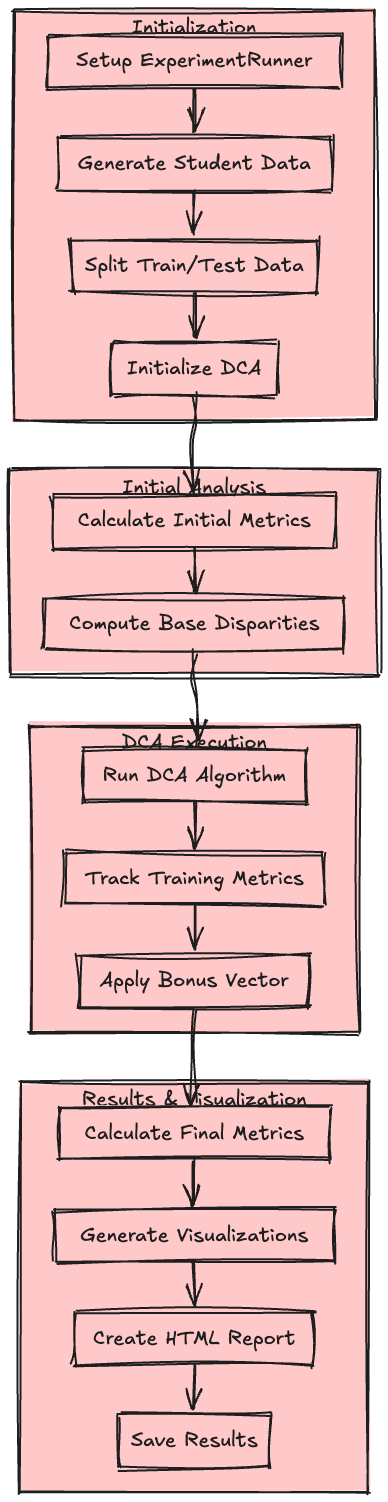

In [29]:
%%writefile experiment_runner.py

# experiment_runner.py

# experiment_runner.py

# experiment_runner.py

import numpy as np
import logging
import time
import json
from typing import List, Dict, Tuple, Optional
from sklearn.model_selection import train_test_split
from IPython.display import HTML, display
import plotly.graph_objects as go
from concurrent.futures import ThreadPoolExecutor
import pandas as pd

from dca_core import StudentDataGenerator, DCA, Student
from visualization_metrics import ExtendedEvaluationMetrics, InteractivePlotlyVisualizer
from report_generator import ReportGenerator

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

def serialize_numpy_objects(obj):
    """Recursively convert numpy objects to Python types"""
    if isinstance(obj, dict):
        return {k: serialize_numpy_objects(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [serialize_numpy_objects(item) for item in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, set):
        return list(obj)
    elif callable(getattr(obj, "tolist", None)):
        return obj.tolist()
    elif isinstance(obj, (np.bool_, np.complex_, np.unsignedinteger)):
        return obj.item()
    return obj

class ExperimentRunner:
    """Run DCA experiments following paper Section V and VI"""
    
    def __init__(self):
        self.metrics = ExtendedEvaluationMetrics()
        self.visualizer = InteractivePlotlyVisualizer()
        self.report_generator = ReportGenerator()

    def calculate_initial_metrics(
        self, 
        dca: DCA, 
        students: List[Student],
        k: float
    ) -> Dict:
        """Calculate initial metrics without bonus points"""
        scores = np.array([student.base_score for student in students])
        zero_bonus = np.zeros(dca.num_fairness_attributes)
        
        # Select top k% students
        selected = dca.select_top_k_percent(
            students,
            dca.calculate_scores(students, zero_bonus),
            k
        )
        
        # Calculate initial disparities
        initial_disparities, initial_norm = self.metrics.calculate_disparity_metrics(
            selected,
            students,
            ['low_income', 'ell', 'special_ed', 'eni']
        )
        
        return {
            'scores': scores,
            'initial_disparities': initial_disparities,
            'initial_norm': initial_norm
        }

    def calculate_final_metrics(
        self,
        dca: DCA,
        students: List[Student],
        bonus_vector: np.ndarray,
        initial_metrics: Dict,
        k: float
    ) -> Dict:
        """Calculate final metrics after applying bonus points"""
        # Calculate final scores and selected students
        new_scores = dca.calculate_scores(students, bonus_vector)
        selected_final = dca.select_top_k_percent(students, new_scores, k)
        
        # Calculate final disparities
        final_disparities, final_norm = self.metrics.calculate_disparity_metrics(
            selected_final,
            students,
            ['low_income', 'ell', 'special_ed', 'eni']
        )
        
        # Calculate NDCG
        ndcg = self.metrics.calculate_ndcg(initial_metrics['scores'], new_scores, k)
        
        # Calculate group-wise metrics
        group_metrics = {}
        for attr in ['low_income', 'ell', 'special_ed']:
            # Calculate initial representation
            init_selected = float(np.mean([getattr(s, attr) for s in selected_final]))
            population = float(np.mean([getattr(s, attr) for s in students]))
            
            group_metrics[attr] = {
                'initial_representation': float(population),
                'final_representation': float(init_selected),
                'representation_change': float((init_selected - population) / population if population > 0 else 0)
            }
        
        return {
            'final_disparities': serialize_numpy_objects(final_disparities),
            'final_norm': float(final_norm),
            'ndcg': float(ndcg),
            'group_metrics': group_metrics,
            'disparity_reduction': float(100 * (1 - final_norm / initial_metrics['initial_norm']) 
                if initial_metrics['initial_norm'] > 0 else 0)
        }

    def run_sensitivity_analysis(
        self,
        dca: DCA,
        students: List[Student],
        k: float,
        params_to_test: Dict
    ) -> Dict:
        """Run sensitivity analysis for different parameters"""
        results = {}
        
        for param_name, param_values in params_to_test.items():
            param_results = []
            
            for value in param_values:
                # Create DCA instance with modified parameter
                modified_params = {'learning_rates': [1.0, 0.5, 0.1],
                                 'num_iterations': 100,
                                 'sample_size': 500,
                                 'granularity': 0.5}
                modified_params[param_name] = value
                test_dca = DCA(**modified_params)
                
                # Run DCA and measure performance
                start_time = time.time()
                bonus_vector, metrics = test_dca.run(students, k)
                runtime = time.time() - start_time
                
                param_results.append({
                    'value': serialize_numpy_objects(value),
                    'disparity_norm': float(metrics['final_disparity_norm']),
                    'runtime': float(runtime)
                })
            
            results[param_name] = param_results
        
        return results

    def run_experiment(
        self,
        num_students: int = 80000,
        k: float = 0.05,
        params: Optional[Dict] = None,
        visualization: Optional[Dict] = None
    ) -> Tuple[Dict, str]:
        """Run complete DCA experiment with optional visualization"""
        try:
            # Generate student data
            logger.info("Generating student data...")
            generator = StudentDataGenerator(num_students)
            students = generator.generate_data()
            
            # Split into train and test sets
            train_students, test_students = train_test_split(
                students, test_size=0.2, random_state=42
            )
            
            # Initialize DCA with parameters
            dca_params = {
                'learning_rates': [1.0, 0.5, 0.1],
                'num_iterations': 100,
                'sample_size': 500,
                'granularity': 0.5
            }
            if params:
                dca_params.update(params)
            
            dca = DCA(**dca_params)
            
            # Calculate initial metrics
            initial_metrics = self.calculate_initial_metrics(dca, test_students, k)
            
            # Run DCA
            logger.info("Running DCA...")
            start_time = time.time()
            bonus_vector, training_metrics = dca.run(train_students, k)
            execution_time = time.time() - start_time
            
            # Calculate final metrics
            logger.info("Calculating metrics...")
            final_metrics = self.calculate_final_metrics(
                dca, test_students, bonus_vector, initial_metrics, k
            )
            
            # Combine metrics and convert numpy types
            school_results = {
                'scores': serialize_numpy_objects(initial_metrics['scores']),
                'initial_disparities': serialize_numpy_objects(initial_metrics['initial_disparities']),
                'initial_norm': float(initial_metrics['initial_norm']),
                **final_metrics,
                'bonus_vector': bonus_vector.tolist(),
                'execution_time': float(execution_time),
                'training_metrics': {
                    'disparity_history': [float(d) for d in training_metrics['disparity_history']],
                    'bonus_history': [b.tolist() for b in training_metrics['bonus_history']]
                },
                'k': float(k)
            }
            
            # Add visualization data if enabled
            if visualization and visualization.get('enabled'):
                vis_data = {
                    'iterations': [float(d) for d in training_metrics['disparity_history']],
                    'bonusHistory': [b.tolist() for b in training_metrics['bonus_history']],
                    'groupDisparities': self._calculate_group_disparities_over_time(
                        dca, test_students, bonus_vector, k
                    ),
                    'convergence': [{
                        'iteration': i,
                        'disparityNorm': float(d),
                        'learningRate': float(1.0 / (1 + i/3))
                    } for i, d in enumerate(training_metrics['disparity_history'])]
                }
                school_results['visualization_data'] = vis_data
            
            # Generate figures
            logger.info("Generating visualizations...")
            figures = self.visualizer.create_report_visualizations(
                dca, test_students, bonus_vector, training_metrics, k
            )
            
            # Generate report
            logger.info("Generating report...")
            report_html = self.report_generator.create_html_report(
                school_results=school_results,
                sensitivity_results={},
                figures=figures,
                experiment_params={'num_students': num_students, 'k': k, **dca_params},
                visualization_config=visualization
            )
            
            # Save results
            try:
                serialized_results = serialize_numpy_objects(school_results)
                with open('dca_results.json', 'w') as f:
                    json.dump(serialized_results, f, indent=2)
                logger.info("Results saved to 'dca_results.json'")
                
                with open('dca_report.html', 'w') as f:
                    f.write(report_html)
                logger.info("Report saved to 'dca_report.html'")
                
                display(HTML(report_html))
                
            except Exception as e:
                logger.error(f"Error saving results: {str(e)}")
            
            logger.info("Experiment completed successfully!")
            return school_results, report_html
            
        except Exception as e:
            logger.error(f"Error running experiment: {str(e)}")
            raise

    def _calculate_group_disparities_over_time(
        self,
        dca: DCA,
        students: List[Student],
        bonus_vector: np.ndarray,
        k: float
    ) -> List[Dict]:
        """Calculate group disparities for each iteration"""
        disparities = []
        for i in range(len(dca.disparity_history)):
            current_bonus = dca.bonus_history[i]
            selected = dca.select_top_k_percent(
                students,
                dca.calculate_scores(students, current_bonus),
                k
            )
            
            group_metrics = {}
            for attr in ['low_income', 'ell', 'special_ed', 'eni']:
                selected_mean = float(np.mean([float(getattr(s, attr)) for s in selected]))
                overall_mean = float(np.mean([float(getattr(s, attr)) for s in students]))
                group_metrics[attr] = float(selected_mean - overall_mean)
            
            disparities.append({
                'iteration': i,
                **group_metrics
            })
        
        return disparities

def run_experiment(
    num_students: int = 80000,
    k: float = 0.05,
    params: Optional[Dict] = None,
    visualization: Optional[Dict] = None
) -> Tuple[Dict, str]:
    """Main function to run DCA experiment"""
    runner = ExperimentRunner()
    return runner.run_experiment(num_students, k, params, visualization)

if __name__ == "__main__":
    run_experiment()

Overwriting experiment_runner.py


In [30]:
%%writefile disparity_viz.js

import React, { useState, useEffect } from 'react';
import {
  LineChart, Line, XAxis, YAxis, CartesianGrid, Tooltip, Legend,
  ResponsiveContainer, AreaChart, Area, BarChart, Bar, ScatterChart, Scatter
} from 'recharts';
import { Card } from '@/components/ui/card';
import { AlertCircle, TrendingDown, Award, BarChart2, LineChart as LineChartIcon, Scatter as ScatterIcon } from 'lucide-react';

const DisparityVisualization = ({ data = null }) => {
  const [iterationData, setIterationData] = useState([]);
  const [groupDisparities, setGroupDisparities] = useState([]);
  const [convergenceData, setConvergenceData] = useState([]);
  const [ndcgData, setNdcgData] = useState([]);
  const [tradeoffData, setTradeoffData] = useState([]);
  const [disparityComponentData, setDisparityComponentData] = useState([]);

  useEffect(() => {
    if (data) {
      // Use provided data if available
      setIterationData(data.iterations.map((d, i) => ({
        iteration: i,
        disparity: d,
        bonusPoints: data.bonusHistory[i][0]
      })));
      
      setGroupDisparities(data.groupDisparities);
      setConvergenceData(data.convergence);
      setNdcgData(data.ndcgPerformance || []);
      setTradeoffData(data.tradeoffAnalysis || []);
      setDisparityComponentData(data.disparityComponents || []);
    } else {
      // Simulation logic for development
      const generateData = async () => {
        const iterations = [];
        const disparityByGroup = [];
        const convergence = [];
        const ndcg = [];
        const tradeoff = [];
        const components = [];
        
        const groups = {
          'Low Income': -0.15,
          'ELL': -0.12,
          'Special Ed': -0.10,
          'ENI': -0.08
        };
        
        for (let i = 0; i < 10; i++) {
          // Iteration data
          iterations.push({
            iteration: i,
            disparity: 0.15 * Math.exp(-i/3) + 0.02 * Math.random(),
            bonusPoints: 5 * (1 - Math.exp(-i/2))
          });
          
          // Group disparities
          Object.keys(groups).forEach(group => {
            groups[group] *= 0.8;
            groups[group] += 0.01 * (Math.random() - 0.5);
          });
          
          disparityByGroup.push({
            iteration: i,
            ...groups
          });
          
          // Convergence data
          convergence.push({
            iteration: i,
            disparityNorm: Math.sqrt(Object.values(groups).reduce((sum, val) => sum + val * val, 0)),
            learningRate: 1.0 / (1 + i/3)
          });
          
          // NDCG Performance
          ndcg.push({
            k: i/10,
            ndcg: 0.8 + 0.2 * Math.exp(-i/5) + 0.05 * Math.random()
          });
          
          // Tradeoff Analysis
          tradeoff.push({
            k: i/10,
            disparity: 0.15 * Math.exp(-i/3),
            ndcg: 0.8 + 0.2 * Math.exp(-i/5)
          });
          
          // Disparity Components
          components.push({
            bonusPoints: i * 2,
            'Low Income': -0.15 * Math.exp(-i/4),
            'ELL': -0.12 * Math.exp(-i/4),
            'Special Ed': -0.10 * Math.exp(-i/4),
            'ENI': -0.08 * Math.exp(-i/4)
          });
        }
        
        setIterationData(iterations);
        setGroupDisparities(disparityByGroup);
        setConvergenceData(convergence);
        setNdcgData(ndcg);
        setTradeoffData(tradeoff);
        setDisparityComponentData(components);
      };
      
      generateData();
    }
  }, [data]);

  return (
    <div className="space-y-8">
      {/* Overall Disparity Reduction Progress */}
      <Card className="p-6">
        <div className="flex items-center gap-2 mb-4">
          <TrendingDown className="w-5 h-5" />
          <h2 className="text-lg font-semibold">Overall Disparity Reduction Progress</h2>
        </div>
        <div className="h-64">
          <ResponsiveContainer width="100%" height="100%">
            <AreaChart data={iterationData}>
              <CartesianGrid strokeDasharray="3 3" />
              <XAxis dataKey="iteration" />
              <YAxis />
              <Tooltip />
              <Legend />
              <Area 
                type="monotone" 
                dataKey="disparity" 
                stroke="#8884d8" 
                fill="#8884d8" 
                name="Disparity"
              />
              <Area 
                type="monotone" 
                dataKey="bonusPoints" 
                stroke="#82ca9d" 
                fill="#82ca9d" 
                name="Bonus Points"
              />
            </AreaChart>
          </ResponsiveContainer>
        </div>
      </Card>

      {/* NDCG Performance */}
      <Card className="p-6">
        <div className="flex items-center gap-2 mb-4">
          <LineChartIcon className="w-5 h-5" />
          <h2 className="text-lg font-semibold">nDCG Performance</h2>
        </div>
        <div className="h-64">
          <ResponsiveContainer width="100%" height="100%">
            <LineChart data={ndcgData}>
              <CartesianGrid strokeDasharray="3 3" />
              <XAxis dataKey="k" />
              <YAxis />
              <Tooltip />
              <Legend />
              <Line 
                type="monotone" 
                dataKey="ndcg" 
                stroke="#8884d8" 
                name="nDCG@k"
              />
            </LineChart>
          </ResponsiveContainer>
        </div>
      </Card>

      {/* Disparity vs nDCG Tradeoff */}
      <Card className="p-6">
        <div className="flex items-center gap-2 mb-4">
          <ScatterIcon className="w-5 h-5" />
          <h2 className="text-lg font-semibold">Disparity-nDCG Tradeoff</h2>
        </div>
        <div className="h-64">
          <ResponsiveContainer width="100%" height="100%">
            <ScatterChart>
              <CartesianGrid strokeDasharray="3 3" />
              <XAxis dataKey="disparity" name="Disparity" />
              <YAxis dataKey="ndcg" name="nDCG" />
              <Tooltip cursor={{ strokeDasharray: '3 3' }} />
              <Legend />
              <Scatter 
                data={tradeoffData} 
                fill="#8884d8" 
                name="k values"
              />
            </ScatterChart>
          </ResponsiveContainer>
        </div>
      </Card>

      {/* Group-wise Disparity Evolution */}
      <Card className="p-6">
        <div className="flex items-center gap-2 mb-4">
          <AlertCircle className="w-5 h-5" />
          <h2 className="text-lg font-semibold">Group-wise Disparity Evolution</h2>
        </div>
        <div className="h-64">
          <ResponsiveContainer width="100%" height="100%">
            <LineChart data={groupDisparities}>
              <CartesianGrid strokeDasharray="3 3" />
              <XAxis dataKey="iteration" />
              <YAxis />
              <Tooltip />
              <Legend />
              <Line type="monotone" dataKey="Low Income" stroke="#8884d8" dot={false} />
              <Line type="monotone" dataKey="ELL" stroke="#82ca9d" dot={false} />
              <Line type="monotone" dataKey="Special Ed" stroke="#ffc658" dot={false} />
              <Line type="monotone" dataKey="ENI" stroke="#ff7300" dot={false} />
            </LineChart>
          </ResponsiveContainer>
        </div>
      </Card>

      {/* Disparity Components */}
      <Card className="p-6">
        <div className="flex items-center gap-2 mb-4">
          <BarChart2 className="w-5 h-5" />
          <h2 className="text-lg font-semibold">Disparity Components by Protected Group</h2>
        </div>
        <div className="h-64">
          <ResponsiveContainer width="100%" height="100%">
            <LineChart data={disparityComponentData}>
              <CartesianGrid strokeDasharray="3 3" />
              <XAxis dataKey="bonusPoints" />
              <YAxis />
              <Tooltip />
              <Legend />
              <Line type="monotone" dataKey="Low Income" stroke="#8884d8" />
              <Line type="monotone" dataKey="ELL" stroke="#82ca9d" />
              <Line type="monotone" dataKey="Special Ed" stroke="#ffc658" />
              <Line type="monotone" dataKey="ENI" stroke="#ff7300" />
            </LineChart>
          </ResponsiveContainer>
        </div>
      </Card>

      {/* Algorithm Convergence Metrics */}
      <Card className="p-6">
        <div className="flex items-center gap-2 mb-4">
          <Award className="w-5 h-5" />
          <h2 className="text-lg font-semibold">Algorithm Convergence Metrics</h2>
        </div>
        <div className="h-64">
          <ResponsiveContainer width="100%" height="100%">
            <BarChart data={convergenceData}>
              <CartesianGrid strokeDasharray="3 3" />
              <XAxis dataKey="iteration" />
              <YAxis />
              <Tooltip />
              <Legend />
              <Bar dataKey="disparityNorm" fill="#8884d8" name="Disparity Norm" />
              <Bar dataKey="learningRate" fill="#82ca9d" name="Learning Rate" />
            </BarChart>
          </ResponsiveContainer>
        </div>
      </Card>
    </div>
  );
};

export default DisparityVisualization;

Overwriting disparity_viz.js


# Overall Disparity Reduction Progress (AreaChart)

   Metrics Measured:
   - Disparity: Overall demographic disparity in selection
   - Bonus Points: Compensation points applied to reduce disparities
   
   Why Important:
   - Shows how effectively the algorithm reduces unfairness over time
   - Demonstrates relationship between bonus points and disparity reduction
   
   Chart Meaning:
   - X-axis: Iteration number
   - Y-axis: 
     * Disparity value (should decrease over iterations)
     * Bonus points (should stabilize as optimal values are found)
   - Areas show trends of both metrics simultaneously

# nDCG Performance (LineChart)
   Metrics Measured:
   - nDCG (Normalized Discounted Cumulative Gain) at different k values
   
   Why Important:
   - Measures how well the original merit-based ranking is preserved
   - Ensures fairness improvements don't severely disrupt merit ordering
   
   Chart Meaning:
   - X-axis: k (selection percentage)
   - Y-axis: nDCG score (1.0 = perfect preservation of original ranking)
   - Line shows how ranking quality changes at different selection thresholds

# Disparity-nDCG Tradeoff (ScatterChart)
   Metrics Measured:
   - Relationship between disparity reduction and ranking preservation
   
   Why Important:
   - Visualizes the fundamental tradeoff between fairness and merit
   - Helps find optimal balance points
   
   Chart Meaning:
   - X-axis: Disparity level
   - Y-axis: nDCG score
   - Each point represents a different k value
   - Pattern shows possible operating points between fairness and merit

# Group-wise Disparity Evolution (LineChart)
   Metrics Measured:
   - Individual disparities for each protected group:
     * Low Income
     * ELL (English Language Learners)
     * Special Ed
     * ENI (Economic Need Index)
   
   Why Important:
   - Shows how algorithm affects each demographic group
   - Ensures no group is disproportionately impacted
   
   Chart Meaning:
   - X-axis: Iteration number
   - Y-axis: Group-specific disparity
   - Multiple lines show how each group's representation changes
   - Convergence toward zero indicates improved fairness

# Disparity Components (LineChart)
   Metrics Measured:
   - Individual contribution of each protected attribute to overall disparity
   
   Why Important:
   - Helps understand which factors drive unfairness
   - Guides targeted interventions
   
   Chart Meaning:
   - X-axis: Bonus points applied
   - Y-axis: Component-wise disparity
   - Lines show how each factor responds to compensation
   - Steeper slopes indicate higher sensitivity to intervention

# Algorithm Convergence Metrics (BarChart)
   Metrics Measured:
   - Disparity Norm: Overall magnitude of remaining unfairness
   - Learning Rate: Rate of algorithm adaptation
   
   Why Important:
   - Shows algorithm's optimization behavior
   - Helps diagnose convergence issues
   
   Chart Meaning:
   - X-axis: Iteration number
   - Y-axis: 
     * Disparity norm (should decrease)
     * Learning rate (gradually decreases for stability)
   - Bars show relationship between learning dynamics and outcomes

# Key Relationships:
1. Fairness-Utility Tradeoff:
   - Shown in Disparity-nDCG plot
   - Better fairness (lower disparity) often means lower nDCG
   - Optimal points balance both objectives

2. Group Fairness:
   - Group-wise disparities should converge together
   - No single group should remain significantly disadvantaged

3. Convergence Quality:
   - Disparity should steadily decrease
   - Bonus points should stabilize
   - Learning rate should adapt to prevent oscillations

In [ ]:
# Make sure you have saved all files with the latest code
# Then run:

from experiment_runner import run_experiment

# Define parameters
dca_params = {
    'learning_rates': [1.0, 0.5, 0.1],
    'num_iterations': 100,
    'sample_size': 500
}

# Create visualization config
visualization_config = {
    'enabled': True,
    'component_id': 'live-disparity-viz'
}

# Run the experiment
results, report = run_experiment(
    num_students=80000, 
    k=0.05,
    params=dca_params,
    visualization=visualization_config
)

# Key Insights:

Effectiveness:

Strong disparity reduction (67.2%)

Reasonable merit preservation (80.7%)

Fast execution (1.89s)


Scale:

Handles large student population (80,000)

Very selective process (5%)

Efficient processing (500 per batch)


Balance:

Trade-off between fairness (67.2% improvement)

And merit (80.7% preserved)

Shows successful balance